In [1]:
%matplotlib inline 

In [2]:
from copy import deepcopy
from itertools import combinations
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
def plot_matrix(data, fig, ax, title):
    """Plot square matrix"""
    # Make indices
    indices = {k: i for i, k in enumerate(data)}
    # Get matrix
    M = jaccardi_matrix(data)
    # Make square similarity matrix
    M0 = np.diagflat(np.ones(len(data)))
    for (i, j), k in M:
        M0[indices[i], indices[j]] = k
        M0[indices[j], indices[i]] = k
    # Plot image
    im = ax.imshow(M0, vmin=0, vmax=1)
    ax.set_title(title)
    # add color axis
    cax = make_axes_locatable(ax).append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    # Use names of enties in data instead of numeric axes
    ticks = list(range(len(data)))
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    labels = {i: k for k, i in indices.items()}
    ax.set_xticklabels([labels[i] for i in range(len(data))])
    ax.set_yticklabels([labels[i] for i in range(len(data))])

In [4]:
def jaccardi(a, b):
    """Calculate Jaccardi similarity
    
    Parameters
    ---------
    a: set
        set to compare
    b: iterable
        set to compare
    Return
    -----
    float:
        jaccardi similarity
    """
    return len(a.intersection(b)) * 1.0 / len(a.union(b))


def jaccardi_matrix(inp):
    """Build jaccardi matrix 
    
    fills flattened upper triangular matrix (indices i>j)

    Parameters
    ----------
    inp: dict(list(str), list(str))
        Input data
        
    Returns:
    list(([int], [int], float))
        indices and distances
    """
    return [((i[0], j[0]), jaccardi(i[1], j[1]))
            for i, j in combinations(inp.items(), 2)]


def jaccardian_cluster(inp, threshold=0.1):
    """Hiearchical clustering on Jaccardi similarity

    Parameters
    ----------
    inp : list(dict(str, list(str)))
        transmitter lists for each input file
    threshold : float, optional
        range[0, 1], 0 will cluster ALL data

    Returns
    -----
    list of made links
    dictionary of clusters
    """
    clusters = deepcopy(inp)  # {k: set(v) for k,v in inp.items()}
    links = []
    score = 1
    while len(clusters) > 1 and score > threshold:
        M = jaccardi_matrix(clusters)
        m = list(map(lambda x: x[1], M))
        a = m.index(max(m))
        score = M[a][1]
        if score < threshold:
            break
        link = tuple([
            y for x in M[a][0] for y in (x if isinstance(x, tuple) else (x, ))
        ])
        value = set()
        for j in M[a][0]:
            value.update(clusters[j])
            del clusters[j]
        links.append((link, score))
        clusters[tuple(link)] = value
    return links, clusters

Input data {'A1': {'b', 'a', 'c'}, 'B2': {'f', 'a', 'd'}, 'C3': {'f', 'e', 'g'}, 'D4': {'x', 'm', 'q'}, 'E5': {'f', 'e', 'a', 'd'}, 'F6': {'l', 'k', 'm'}}
Made 4 links to form 2 from 6 entries
Links [(('B2', 'E5'), 0.75), (('C3', 'B2', 'E5'), 0.4), (('D4', 'F6'), 0.2), (('A1', 'C3', 'B2', 'E5'), 0.14285714285714285)]
Final clusters: {('D4', 'F6'): {'m', 'k', 'l', 'x', 'q'}, ('A1', 'C3', 'B2', 'E5'): {'d', 'g', 'f', 'a', 'c', 'b', 'e'}}


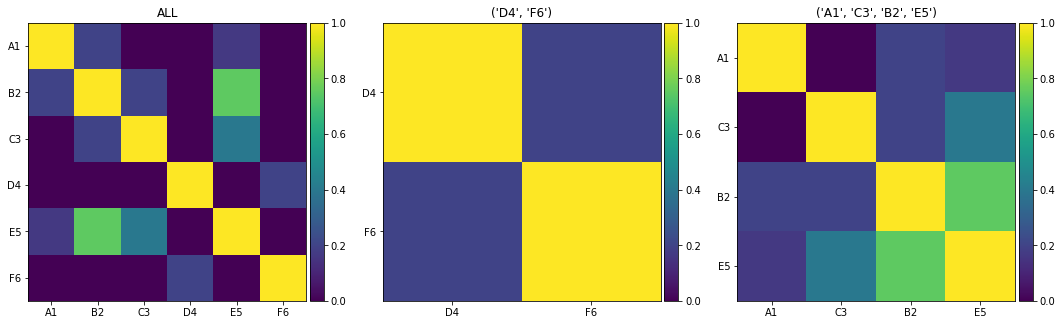

In [5]:
"""
Simple example with 2 sets without relations (A, B, C, E) and (D, F)

In real life this would correspond to recordings (A-F) each seeing different
sets of transmitters.
"""

data = {
    "A1": ["a", "b", "c"],
    "B2": ["a", "f", "d"],
    "C3": ["g", "e", "f"],
    "D4": ["m", "x", "q"],
    "E5": ["a", "e", "d", "f"],
    "F6": ["k", "l", "m"]
}
# Make sets from the input lists
data = {k: set(v) for k, v in data.items()}
print("Input data {}".format(data))

# Perform clustering
links, clusters = jaccardian_cluster(data)
nclusters = len(clusters)
print("Made {} links to form {} from {} entries".format(
    len(links), nclusters, len(data)))
print("Links {}".format(links))
print("Final clusters: {}".format(clusters))

# Make plots
sz = 6  # fig size multiplier
fig, ax = plt.subplots(1, nclusters + 1, figsize=(sz * (nclusters + 1), sz))
plot_matrix(data, fig, ax[0], title="{}".format("ALL"))
for i, (k, v) in enumerate(clusters.items()):
    subset = {ki: data[ki] for ki in k}
    plot_matrix(subset, fig, ax[i + 1], title="{}".format(k))